# Model Evaluation & Selection: Aspect-based Sentiment Analysis 
**`Aspect-based Sentiment Analysis`** | **`Aspect Extraction`** | **`Aspect Sentiment Prediction`**

**`Goal:`** 

Compare the performance of the three different model approaches (pos-tagging with word similarity, binary relevance, and multilabel classification) on the validation and test sets to settle on a final method to be used for our prediction tasks.

Here the main metric of interest is the weighted F-0.5 score for aspect extraction and micro accuracy for aspect sentiment prediction

**`Note:`** The validation results here will differ from those seen in [6.2.2.1](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/blob/main/notebooks/6.2.2.1-modeling-absa(ae)-binary-relevance(f1-score).ipynb) and [6.2.2.2](https://github.com/KoredeAkande/nigerian_isp_sentiment_analysis/blob/main/notebooks/6.2.2.2-modeling-absa(ae)-binary-relevance-bertweet(f0.5-score).ipynb). This is because here the model is run on the entire validation set in one-pass while in the other notebooks, the models were run on batches of the data (hence, the validation metrics we saw then were based on batches of the validation set)

## 1. Import packages

In [1]:
import sys
sys.path.append("/Users/koredeakande/Documents/Capstone/ISP Project/Coding/nigerian_isp_sentiment_analysis/py_scripts")
import pandas as pd
import clean_tweets

#Note: The module below was personally designed to compute the metrics given the dataset structure
from absa_metrics import weighted_binary_precision_recall_fscore, aspect_sentiment_accuracy

#Visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

## 2. Load the evaluation data

**Validation dataset**

In [2]:
eval_val_df = pd.read_csv("../data/model-evaluation/validation_dataset.csv")
eval_val_df.head()

,Text,price,speed,reliability,coverage,customer service,Aspects,Sentiment
0,officialkome_ spectranet_ng this people don fr...,0,0,0,0,0,[None],[None]
1,ayomikun_o_ yoruba_dev spectranet_ng i'm.yet t...,0,0,0,0,0,[None],[None]
2,spectranet !!!!! 🤬🤬🤬🤬🤬🤬,0,0,0,0,0,[None],[None]
3,"after buying data see airtel telling me ""now t...",0,0,0,0,0,[None],[None]
4,spectranet ooooo,0,0,0,0,0,[None],[None]


**Test dataset**

In [3]:
eval_test_df = pd.read_csv("../data/model-evaluation/test_dataset.csv")
eval_test_df.head()

,Text,price,speed,reliability,coverage,customer service,Aspects,Sentiment
0,deejay_klem smilecomsng well this means i will...,0,0,0,0,0,[None],[None]
1,myaccessbank hello please i can't seem to find...,0,0,0,0,0,[None],[None]
2,spectranet_ng hello please can i add multiple ...,0,0,0,0,0,[None],[None]
3,spectranet is shit,0,0,0,0,0,[None],[None]
4,"tizeti is a special brand of useless, when it ...",0,1,0,0,0,['speed'],['Negative']


## 3. Load the models

### a. Load the multilabel classifier

In [5]:
sys.path.append("../models/full_absa_models")
import multi_label_bertweet_classifier

Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized from the model checkpoint at absa/classifier-rest-0.2 and are newly initialized: ['dropout_112']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
All TF 2.0 model w

### b. Load the POS tagger with word similarity model

In [6]:
import pos_word_similarity_model

Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertABSClassifier from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of BertABSClassifier were not initialized from the model checkpoint at absa/classifier-rest-0.2 and are newly initialized: ['dropout_187']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### c. Load the binary relevance model

In [4]:
#sys.path.append("../models/full_absa_models")
import binary_relevance_model

2022-04-01 21:00:52.597805: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some layers from the model checkpoint at absa/classifier-rest-0.2 were not used when initializing BertABSClassifier: ['dropout_379']
- This IS expected if you are initializing BertABSClassifier from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertAB

---

## Modeling: Validation set

### a. Model 1: POS Tagger with word similarity

#### (i) Perform slight cleaning of the tweets

In [5]:
#Clean the validation set tweets
model_1_cleaned_val = clean_tweets.run_cleaner(eval_val_df,'Text',no_punc=True,
                                               no_emoji=True, no_isp_name=True)

model_1_cleaned_val.head()

,Text,price,speed,reliability,coverage,customer service,Aspects,Sentiment
0,officialkome spectranetng this people don frus...,0,0,0,0,0,[None],[None]
1,ayomikuno yorubadev spectranetng imyet to turn...,0,0,0,0,0,[None],[None]
2,spectranet,0,0,0,0,0,[None],[None]
3,after buying data see airtel telling me now th...,0,0,0,0,0,[None],[None]
4,spectranet ooooo,0,0,0,0,0,[None],[None]


#### (ii) Run ABSA model on the tweets
*Takes a couple of seconds to run*

In [9]:
pos_word_sim_absa = pos_word_similarity_model.run(model_1_cleaned_val, 'Text')

../models/full_absa_models/pos_word_similarity_model.py:154: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_score = round(asp_token.similarity(spacy_token),1)


#### (iii) Merge true annotations on the model's predictions

In [10]:
pos_word_sim_absa[['Aspects', 'Sentiment']] = model_1_cleaned_val[['Aspects', 'Sentiment']]
pos_word_sim_absa.head()

,Text,Detected aspects,Corresponding sentiment,Aspects,Sentiment
0,officialkome spectranetng this people don frus...,[None],[None],[None],[None]
1,ayomikuno yorubadev spectranetng imyet to turn...,[None],[None],[None],[None]
2,spectranet,[None],[None],[None],[None]
3,after buying data see airtel telling me now th...,[None],[None],[None],[None]
4,spectranet ooooo,[None],[None],[None],[None]


#### (iv) Aspect extraction evaluation

In [11]:
#Calculate precision, recall and f-0.5
md1_class_metrics, md1_precision, md1_recall, md1_fscore = weighted_binary_precision_recall_fscore(
    pos_word_sim_absa['Aspects'],
    pos_word_sim_absa['Detected aspects'], 
    beta = 0.5)

print(f"Precision: {md1_precision:.3f}  Recall: {md1_recall:.3f} F-0.5: {md1_fscore:.3f}")

Precision: 0.301  Recall: 0.033 F-0.5: 0.110


In [12]:
md1_df = pd.DataFrame(md1_class_metrics)
(md1_df.T).iloc[:,-4:]

,Support,Precision,Recall,F-0.5
price,12.0,0.000000,0.000000,0.000000
speed,13.0,1.000000,0.076923,0.294118
reliability,11.0,0.000000,0.000000,0.000000
coverage,9.0,0.000000,0.000000,0.000000
customer service,16.0,0.333333,0.062500,0.178571


#### (iv) Aspect sentiment prediction evaluation

In [13]:
md1_accuracies,md1_micro_accuracy,md1_macro_accuracy=aspect_sentiment_accuracy(pos_word_sim_absa['Aspects'],
                                                                          pos_word_sim_absa['Detected aspects'],
                                                                          pos_word_sim_absa['Sentiment'],
                                                                          pos_word_sim_absa['Corresponding sentiment'])

print(f"Micro accuracy:{md1_micro_accuracy:.3f}   Macro accuracy:{md1_macro_accuracy:.3f}")

Micro accuracy:0.500   Macro accuracy:0.500


In [14]:
(pd.DataFrame([md1_accuracies]).T).rename(columns={0:'Accuracy'})

,Accuracy
price,No prediction for this aspect
speed,0.0
reliability,No prediction for this aspect
coverage,No prediction for this aspect
customer service,1.0


---

### b. Model 2: Binary Relevance Model

#### (i) Run ABSA model on the tweets
*Takes a couple of seconds to run*

In [6]:
binary_relevance_absa = binary_relevance_model.run(eval_val_df, 'Text')

#### (ii) Merge true annotations on the model's predictions

In [7]:
binary_relevance_absa[['Aspects', 'Sentiment']] = model_1_cleaned_val[['Aspects', 'Sentiment']]
binary_relevance_absa.head()

,Text,Detected aspects,Predicted sentiment,Aspects,Sentiment
0,officialkome spectranetng this people don frus...,[None],[None],[None],[None]
1,ayomikuno yorubadev spectranetng imyet to turn...,[None],[None],[None],[None]
2,spectranet,[None],[None],[None],[None]
3,after buying data see airtel telling me now th...,[None],[None],[None],[None]
4,spectranet ooooo,[None],[None],[None],[None]


#### (iii) Aspect extraction evaluation

In [8]:
#Calculate precision, recall and f-0.5
md2_class_metrics, md2_precision, md2_recall, md2_fscore = weighted_binary_precision_recall_fscore(
    binary_relevance_absa['Aspects'],
    binary_relevance_absa['Detected aspects'], 
    beta = 0.5)

print(f"Precision: {md2_precision:.3f}  Recall: {md2_recall:.3f} F-0.5: {md2_fscore:.3f}")

Precision: 0.843  Recall: 0.754 F-0.5: 0.819


In [9]:
md2_df = pd.DataFrame(md2_class_metrics)
(md2_df.T).iloc[:,-4:]

,Support,Precision,Recall,F-0.5
price,12.0,0.818182,0.750000,0.803571
speed,13.0,0.846154,0.846154,0.846154
reliability,11.0,0.769231,0.909091,0.793651
coverage,9.0,0.833333,0.555556,0.757576
customer service,16.0,0.916667,0.687500,0.859375


#### (iv) Aspect sentiment prediction evaluation

In [10]:
md2_accuracies,md2_micro_accuracy,md2_macro_accuracy, md2_extraction_support = aspect_sentiment_accuracy(binary_relevance_absa['Aspects'],
                                                                          binary_relevance_absa['Detected aspects'],
                                                                          binary_relevance_absa['Sentiment'],
                                                                          binary_relevance_absa['Predicted sentiment'])

print(f" Correct extractions:{md2_extraction_support} \n Micro accuracy:{md2_micro_accuracy:.3f}   Macro accuracy:{md2_macro_accuracy:.3f}")

 Correct extractions:{'price': 9, 'speed': 11, 'reliability': 10, 'coverage': 5, 'customer service': 11} 
 Micro accuracy:0.739   Macro accuracy:0.754


In [11]:
(pd.DataFrame([md2_accuracies]).T).rename(columns={0:'Accuracy'})

,Accuracy
price,0.222222
speed,0.636364
reliability,1.000000
coverage,1.000000
customer service,0.909091


### c. Model 3: Multi-label BERTweet Classifier

#### (i) Run ABSA model on the tweets
*Takes a couple of seconds to run*

In [22]:
mlc_absa = multi_label_bertweet_classifier.run(eval_val_df, 'Text')

#### (ii) Merge true annotations on the model's predictions

In [23]:
mlc_absa[['Aspects', 'Sentiment']] = model_1_cleaned_val[['Aspects', 'Sentiment']]
mlc_absa.head()

,Text,Detected aspects,Predicted sentiment,Aspects,Sentiment
0,officialkome spectranetng this people don frus...,[None],[None],[None],[None]
1,ayomikuno yorubadev spectranetng imyet to turn...,[None],[None],[None],[None]
2,spectranet,[None],[None],[None],[None]
3,after buying data see airtel telling me now th...,[None],[None],[None],[None]
4,spectranet ooooo,[None],[None],[None],[None]


#### (iii) Aspect extraction evaluation

In [24]:
#Calculate precision, recall and f-0.5
md3_class_metrics, md3_precision, md3_recall, md3_fscore = weighted_binary_precision_recall_fscore(
    mlc_absa['Aspects'],
    mlc_absa['Detected aspects'], 
    beta = 0.5)

print(f"Precision: {md3_precision:.3f}  Recall: {md3_recall:.3f} F-0.5: {md3_fscore:.3f}")

Precision: 0.483  Recall: 0.279 F-0.5: 0.359


In [25]:
md3_df = pd.DataFrame(md3_class_metrics)
(md3_df.T).iloc[:,-4:]

,Support,Precision,Recall,F-0.5
price,12.0,0.200000,0.250000,0.208333
speed,13.0,0.500000,0.153846,0.344828
reliability,11.0,0.083333,0.090909,0.084746
coverage,9.0,1.000000,0.111111,0.384615
customer service,16.0,0.666667,0.625000,0.657895


#### (iv) Aspect sentiment prediction evaluation

In [26]:
md3_accuracies,md3_micro_accuracy,md3_macro_accuracy=aspect_sentiment_accuracy(mlc_absa['Aspects'],
                                                                          mlc_absa['Detected aspects'],
                                                                          mlc_absa['Sentiment'],
                                                                          mlc_absa['Predicted sentiment'])

print(f"Micro accuracy:{md3_micro_accuracy:.3f}   Macro accuracy:{md3_macro_accuracy:.3f}")

Micro accuracy:0.882   Macro accuracy:0.867


In [27]:
(pd.DataFrame([md3_accuracies]).T).rename(columns={0:'Accuracy'})

,Accuracy
price,0.333333
speed,1.000000
reliability,1.000000
coverage,1.000000
customer service,1.000000


## Visualize F-0.5 performance

In [28]:
joint_df = pd.DataFrame()

model_dfs = [('POS tagger + word similarity',md1_df),
             ('Binary relevance', md2_df),
             ('Multi-label BERTweet', md3_df)]

for model_name, df in model_dfs:
    
    df_transpose = pd.DataFrame(df.loc['F-0.5',:].rename(model_name)).T
    joint_df = joint_df.append(df_transpose)
    
joint_df

,price,speed,reliability,coverage,customer service
POS tagger + word similarity,0.000000,0.294118,0.000000,0.000000,0.178571
Binary relevance,0.803571,0.846154,0.793651,0.757576,0.859375
Multi-label BERTweet,0.208333,0.344828,0.084746,0.384615,0.657895


In [29]:
joint_df = joint_df.reset_index().rename(columns={'index':'model'})
joint_df

,model,price,speed,reliability,coverage,customer service
0,POS tagger + word similarity,0.000000,0.294118,0.000000,0.000000,0.178571
1,Binary relevance,0.803571,0.846154,0.793651,0.757576,0.859375
2,Multi-label BERTweet,0.208333,0.344828,0.084746,0.384615,0.657895


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  


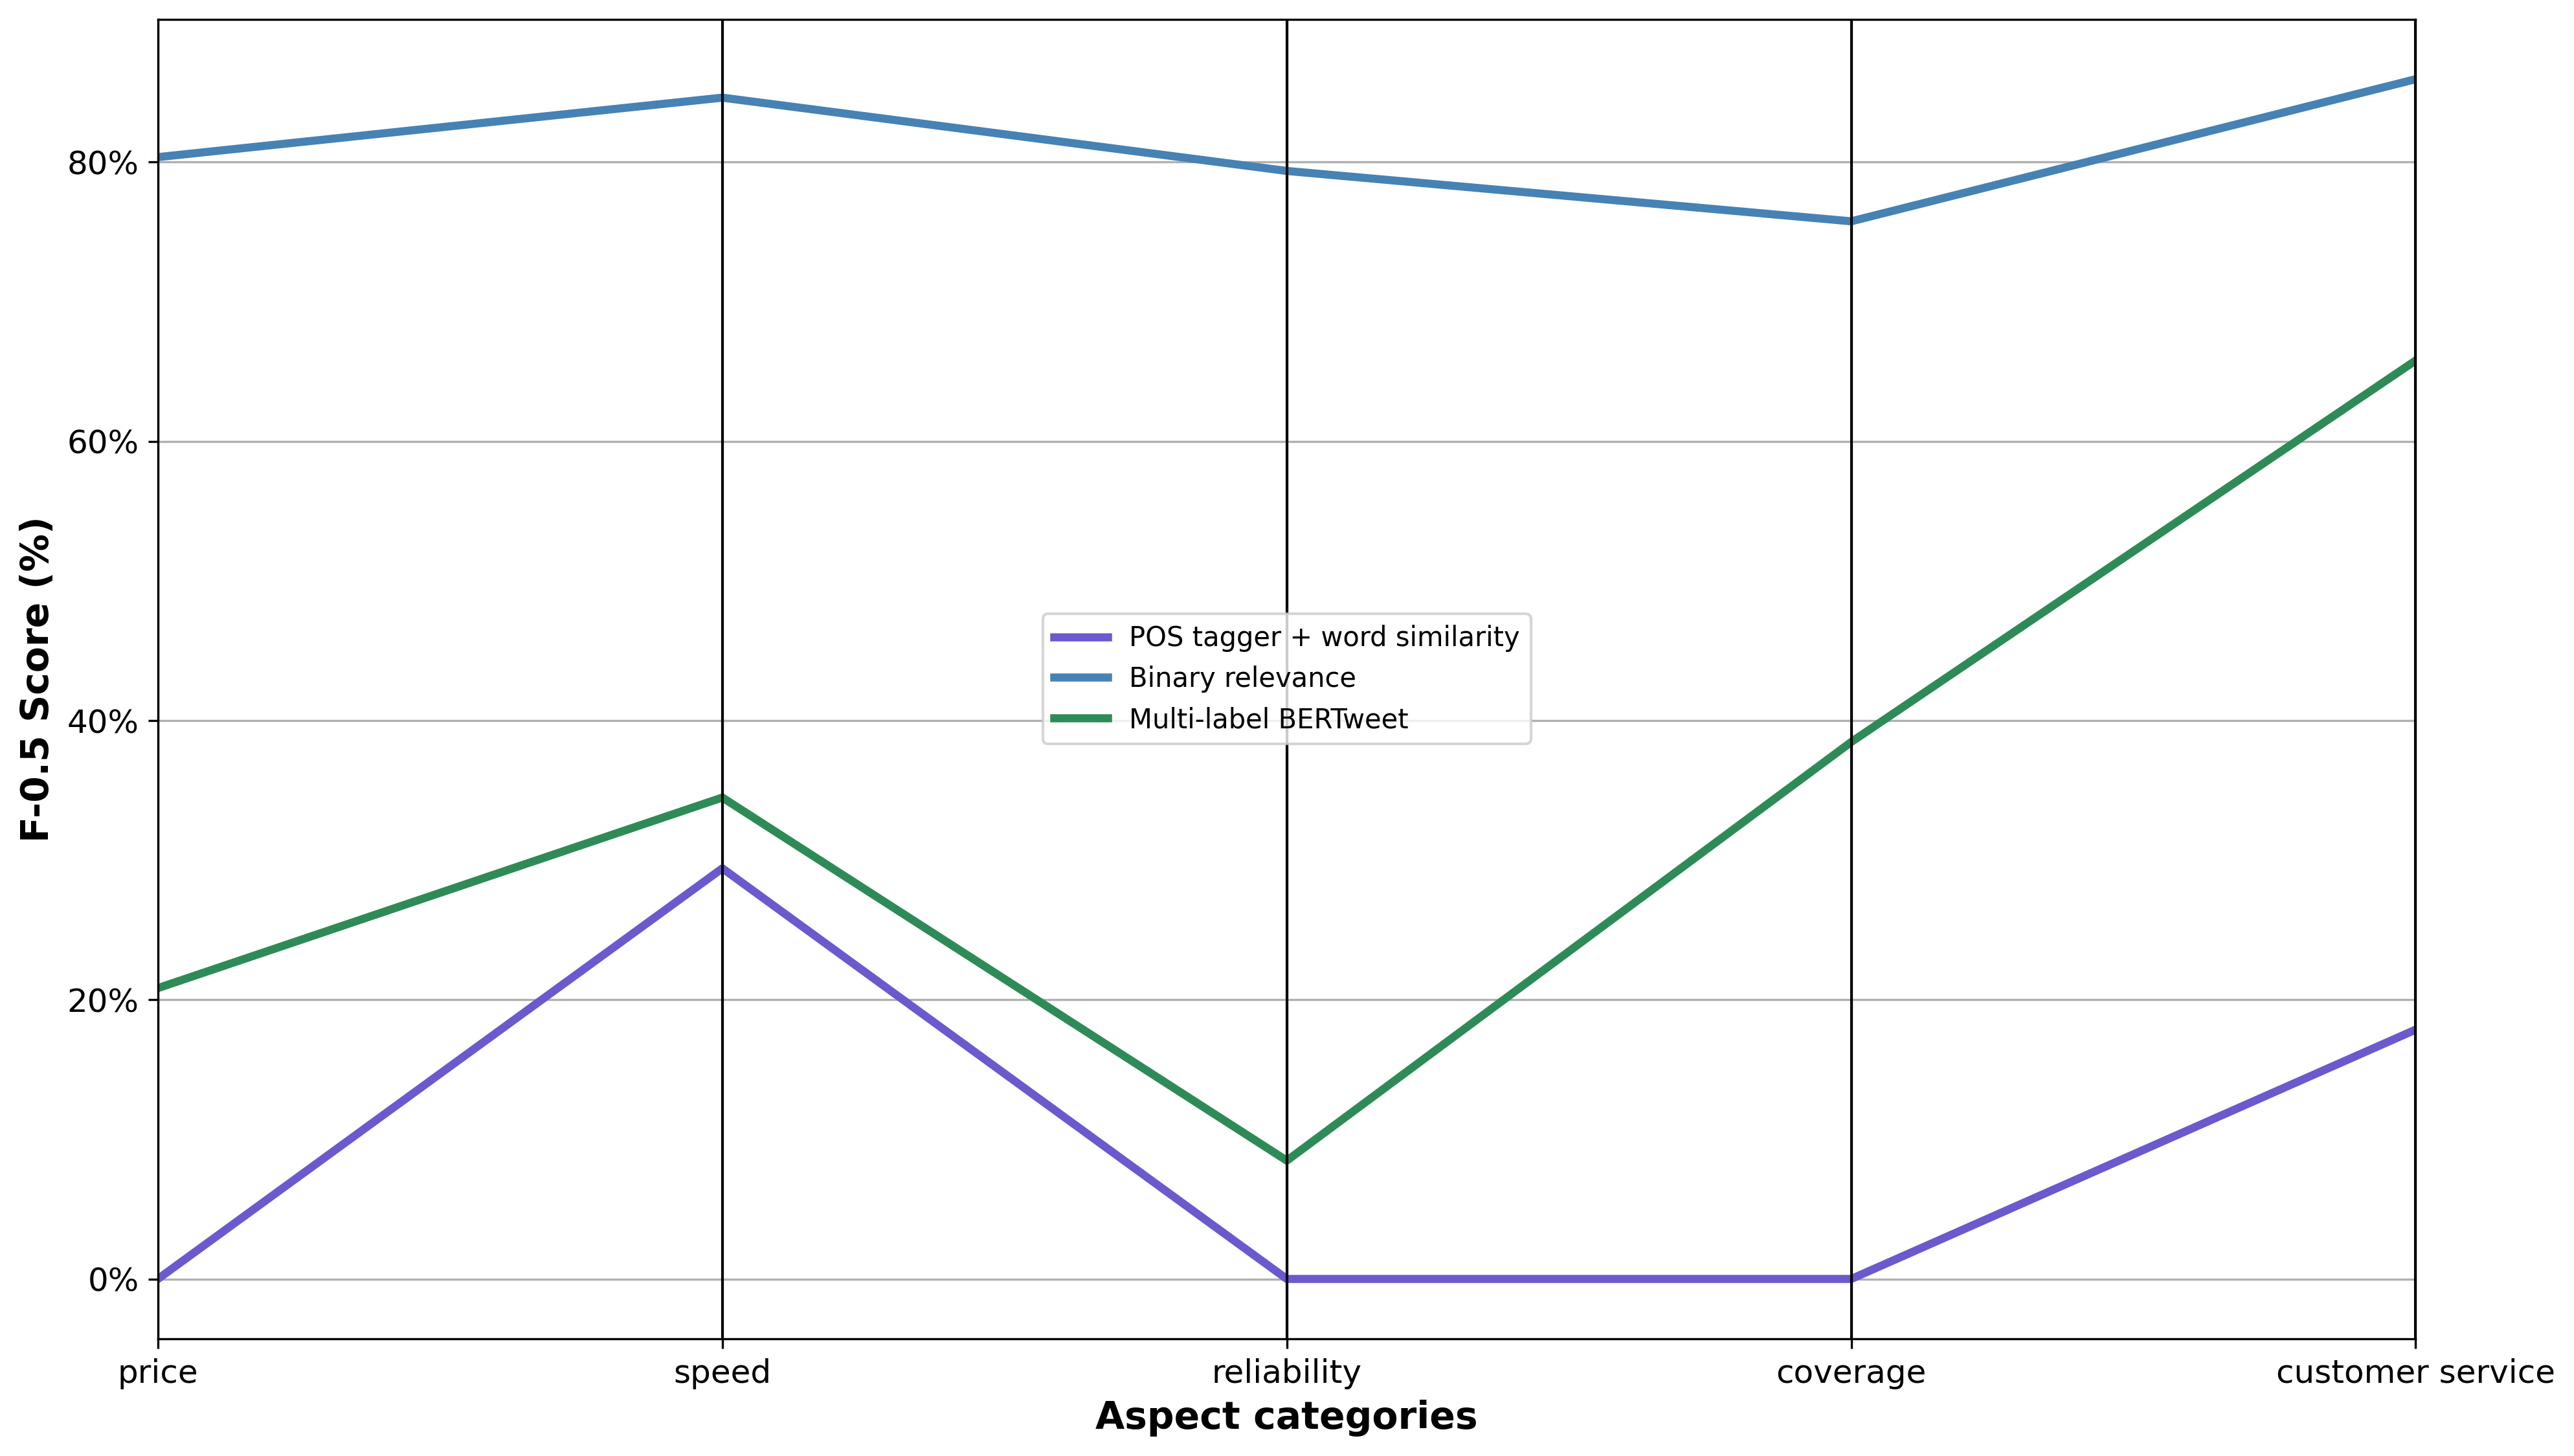

In [33]:
#Create plot
plt.figure(figsize=(15, 9), dpi=300)
parallel_coordinates(joint_df,'model', linewidth=3, color=('slateblue','steelblue','seagreen'))
plt.ylabel('F-0.5 Score (%)',fontsize=14, fontweight= 'bold')
plt.xlabel('Aspect categories',fontsize=14, fontweight= 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend(loc='center')
plt.show()

---

## Binary Relevance Performance on the test set

#### (i) Run ABSA model on the tweets
*Takes a couple of seconds to run*

In [12]:
binary_relevance_test_absa = binary_relevance_model.run(eval_test_df, 'Text')

#### (ii) Merge true annotations on the model's predictions

In [13]:
binary_relevance_test_absa[['Aspects', 'Sentiment']] = eval_test_df[['Aspects', 'Sentiment']]
binary_relevance_test_absa.head()

,Text,Detected aspects,Predicted sentiment,Aspects,Sentiment
0,deejay_klem smilecomsng well this means i will...,[None],[None],[None],[None]
1,myaccessbank hello please i can't seem to find...,[None],[None],[None],[None]
2,spectranet_ng hello please can i add multiple ...,[None],[None],[None],[None]
3,spectranet is shit,[None],[None],[None],[None]
4,"tizeti is a special brand of useless, when it ...",[speed],[Negative],['speed'],['Negative']


#### (iii) Aspect extraction evaluation

In [14]:
#Calculate precision, recall and f-0.5
test_class_metrics, test_precision, test_recall, test_fscore = weighted_binary_precision_recall_fscore(
    binary_relevance_test_absa['Aspects'],
    binary_relevance_test_absa['Detected aspects'], 
    beta = 0.5)

print(f"Precision: {test_precision:.3f}  Recall: {test_recall:.3f} F-0.5: {test_fscore:.3f}")

Precision: 0.897  Recall: 0.789 F-0.5: 0.868


In [15]:
test_metrics_df = pd.DataFrame(test_class_metrics)
(test_metrics_df.T).iloc[:,-4:]

,Support,Precision,Recall,F-0.5
price,12.0,0.833333,0.833333,0.833333
speed,13.0,0.800000,0.923077,0.821918
reliability,14.0,1.000000,0.714286,0.925926
coverage,9.0,0.857143,0.666667,0.810811
customer service,9.0,1.000000,0.777778,0.945946


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


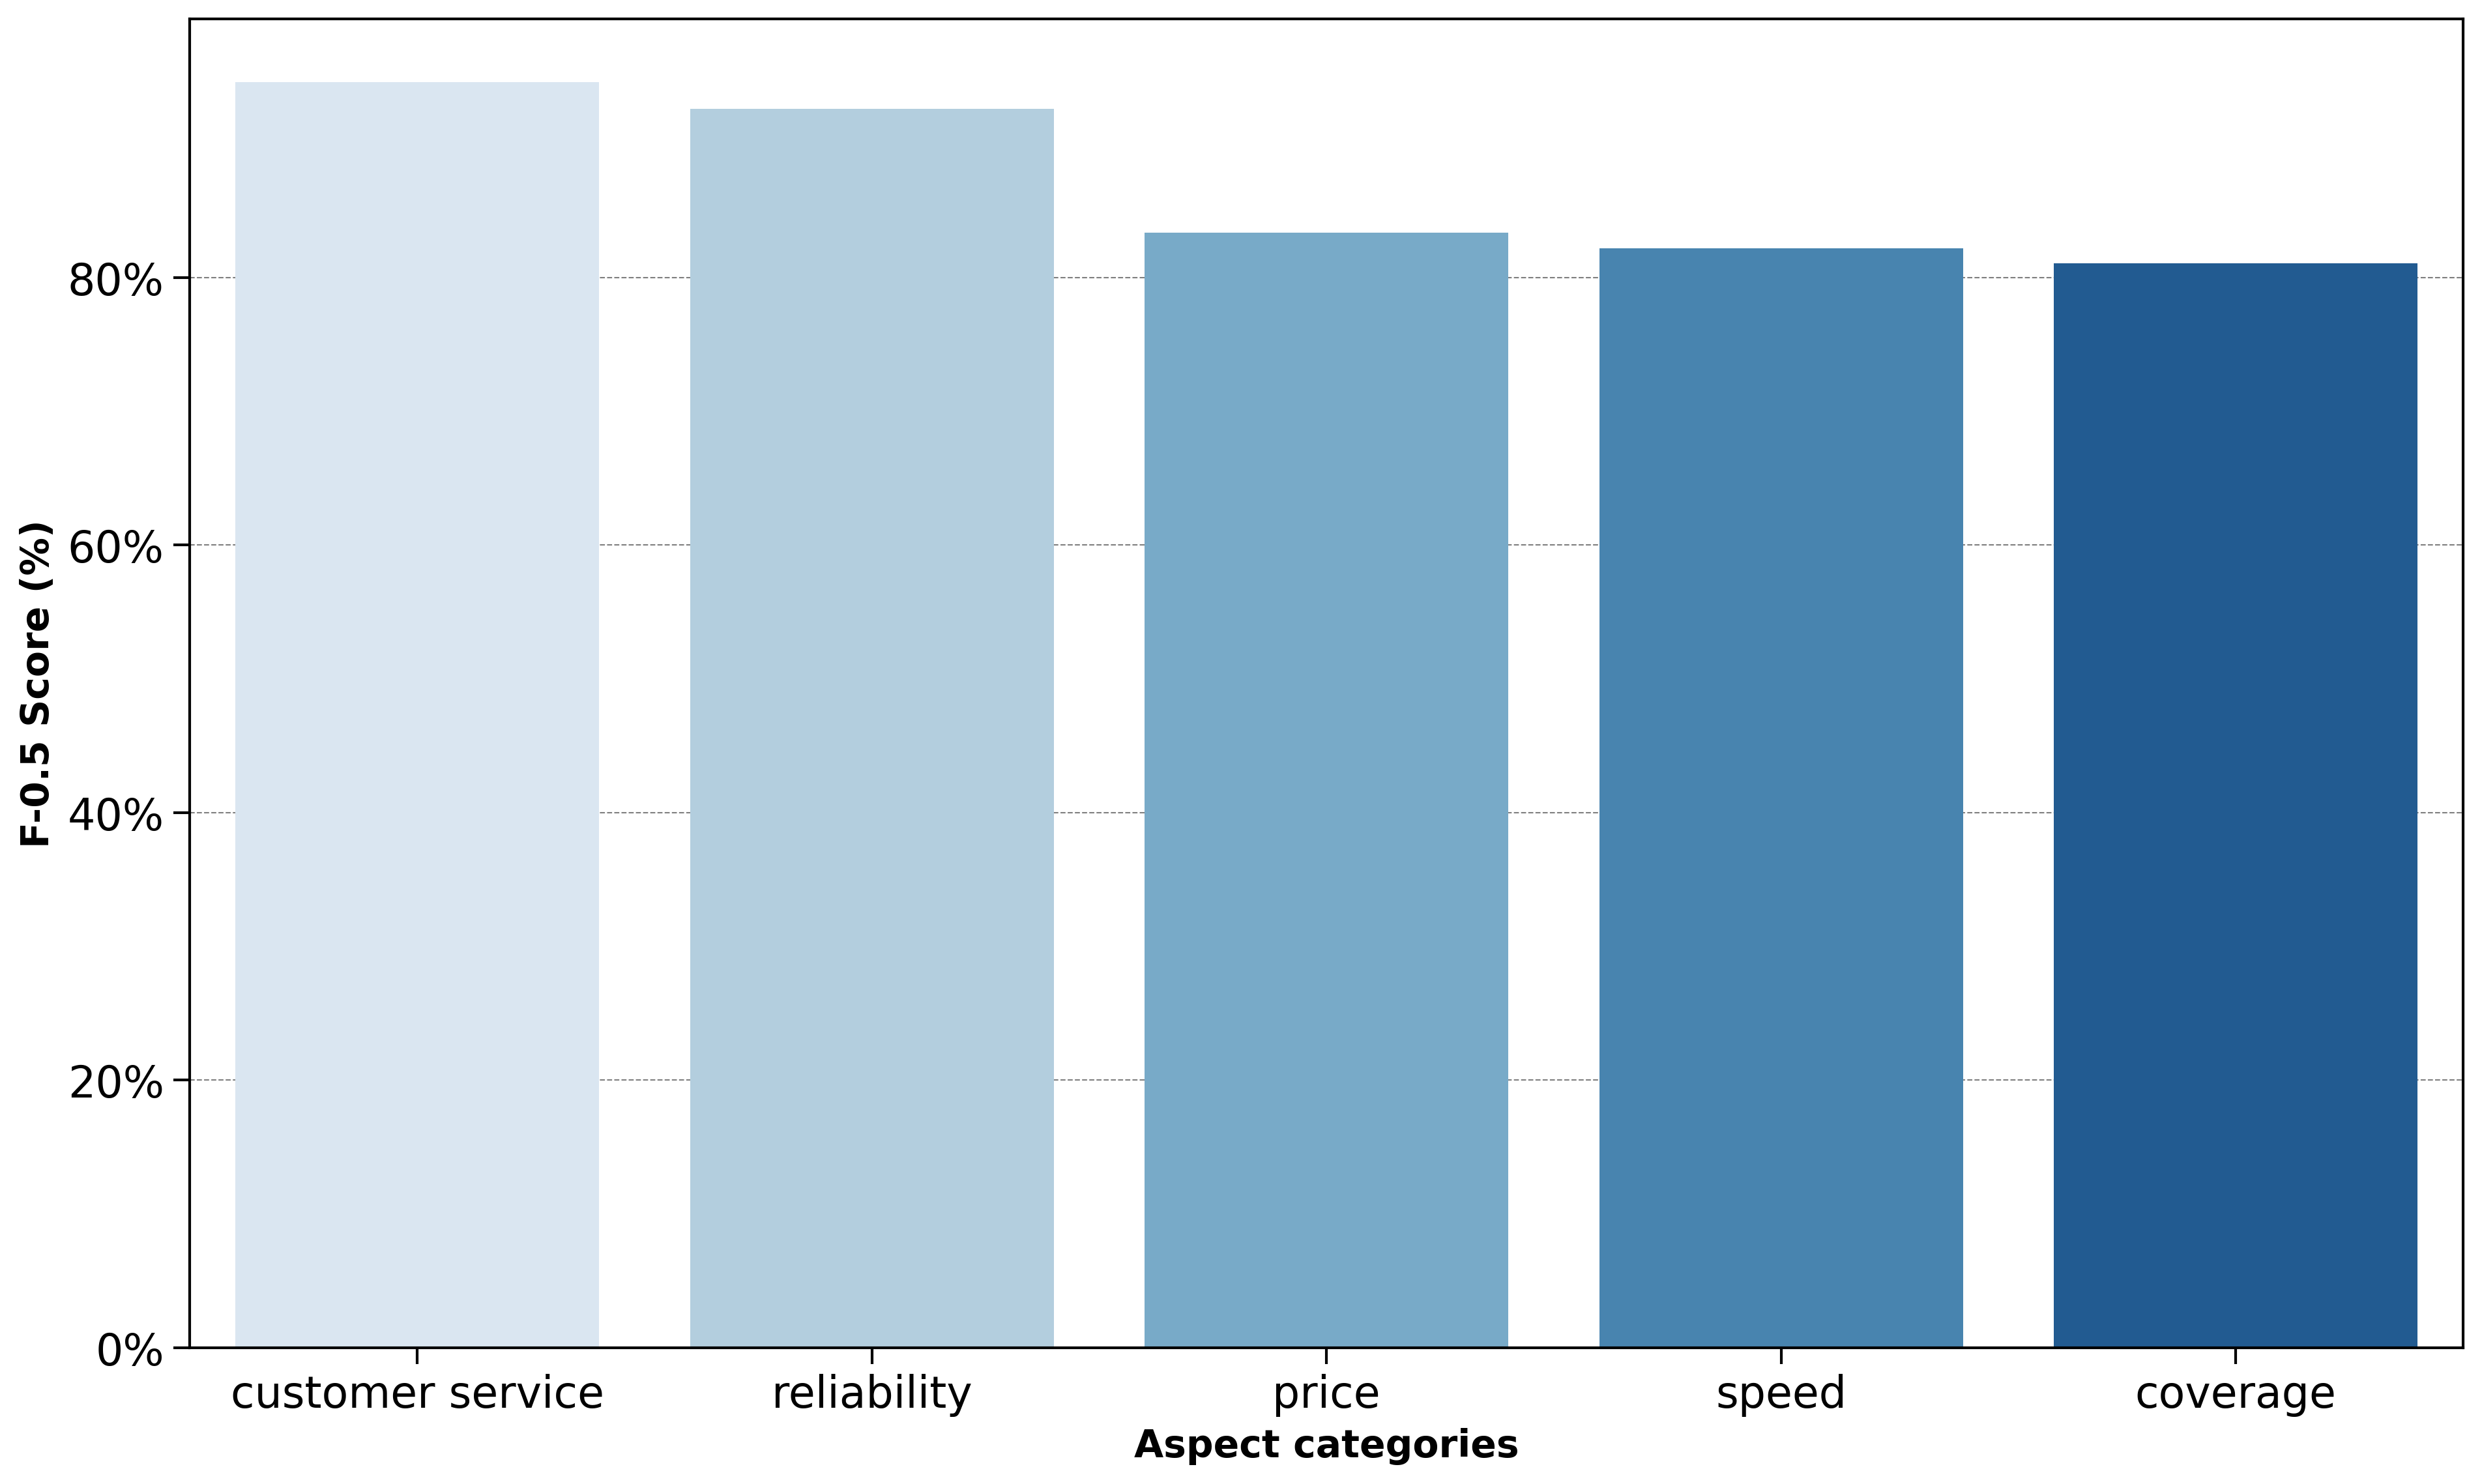

In [11]:
plt.figure(figsize=(15,9), dpi=300)
with plt.style.context(['notebook','no-latex','grid']):
    sns.barplot(data=pd.DataFrame(test_metrics_df.loc['F-0.5',:]).sort_values('F-0.5', ascending=False).T, 
                palette = "Blues")
    plt.ylabel('F-0.5 Score (%)',fontsize=14, fontweight= 'bold')
    plt.xlabel('Aspect categories',fontsize=14, fontweight= 'bold')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.show()

## Plots side by side

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  # This is added back by InteractiveShellApp.init_path()
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator


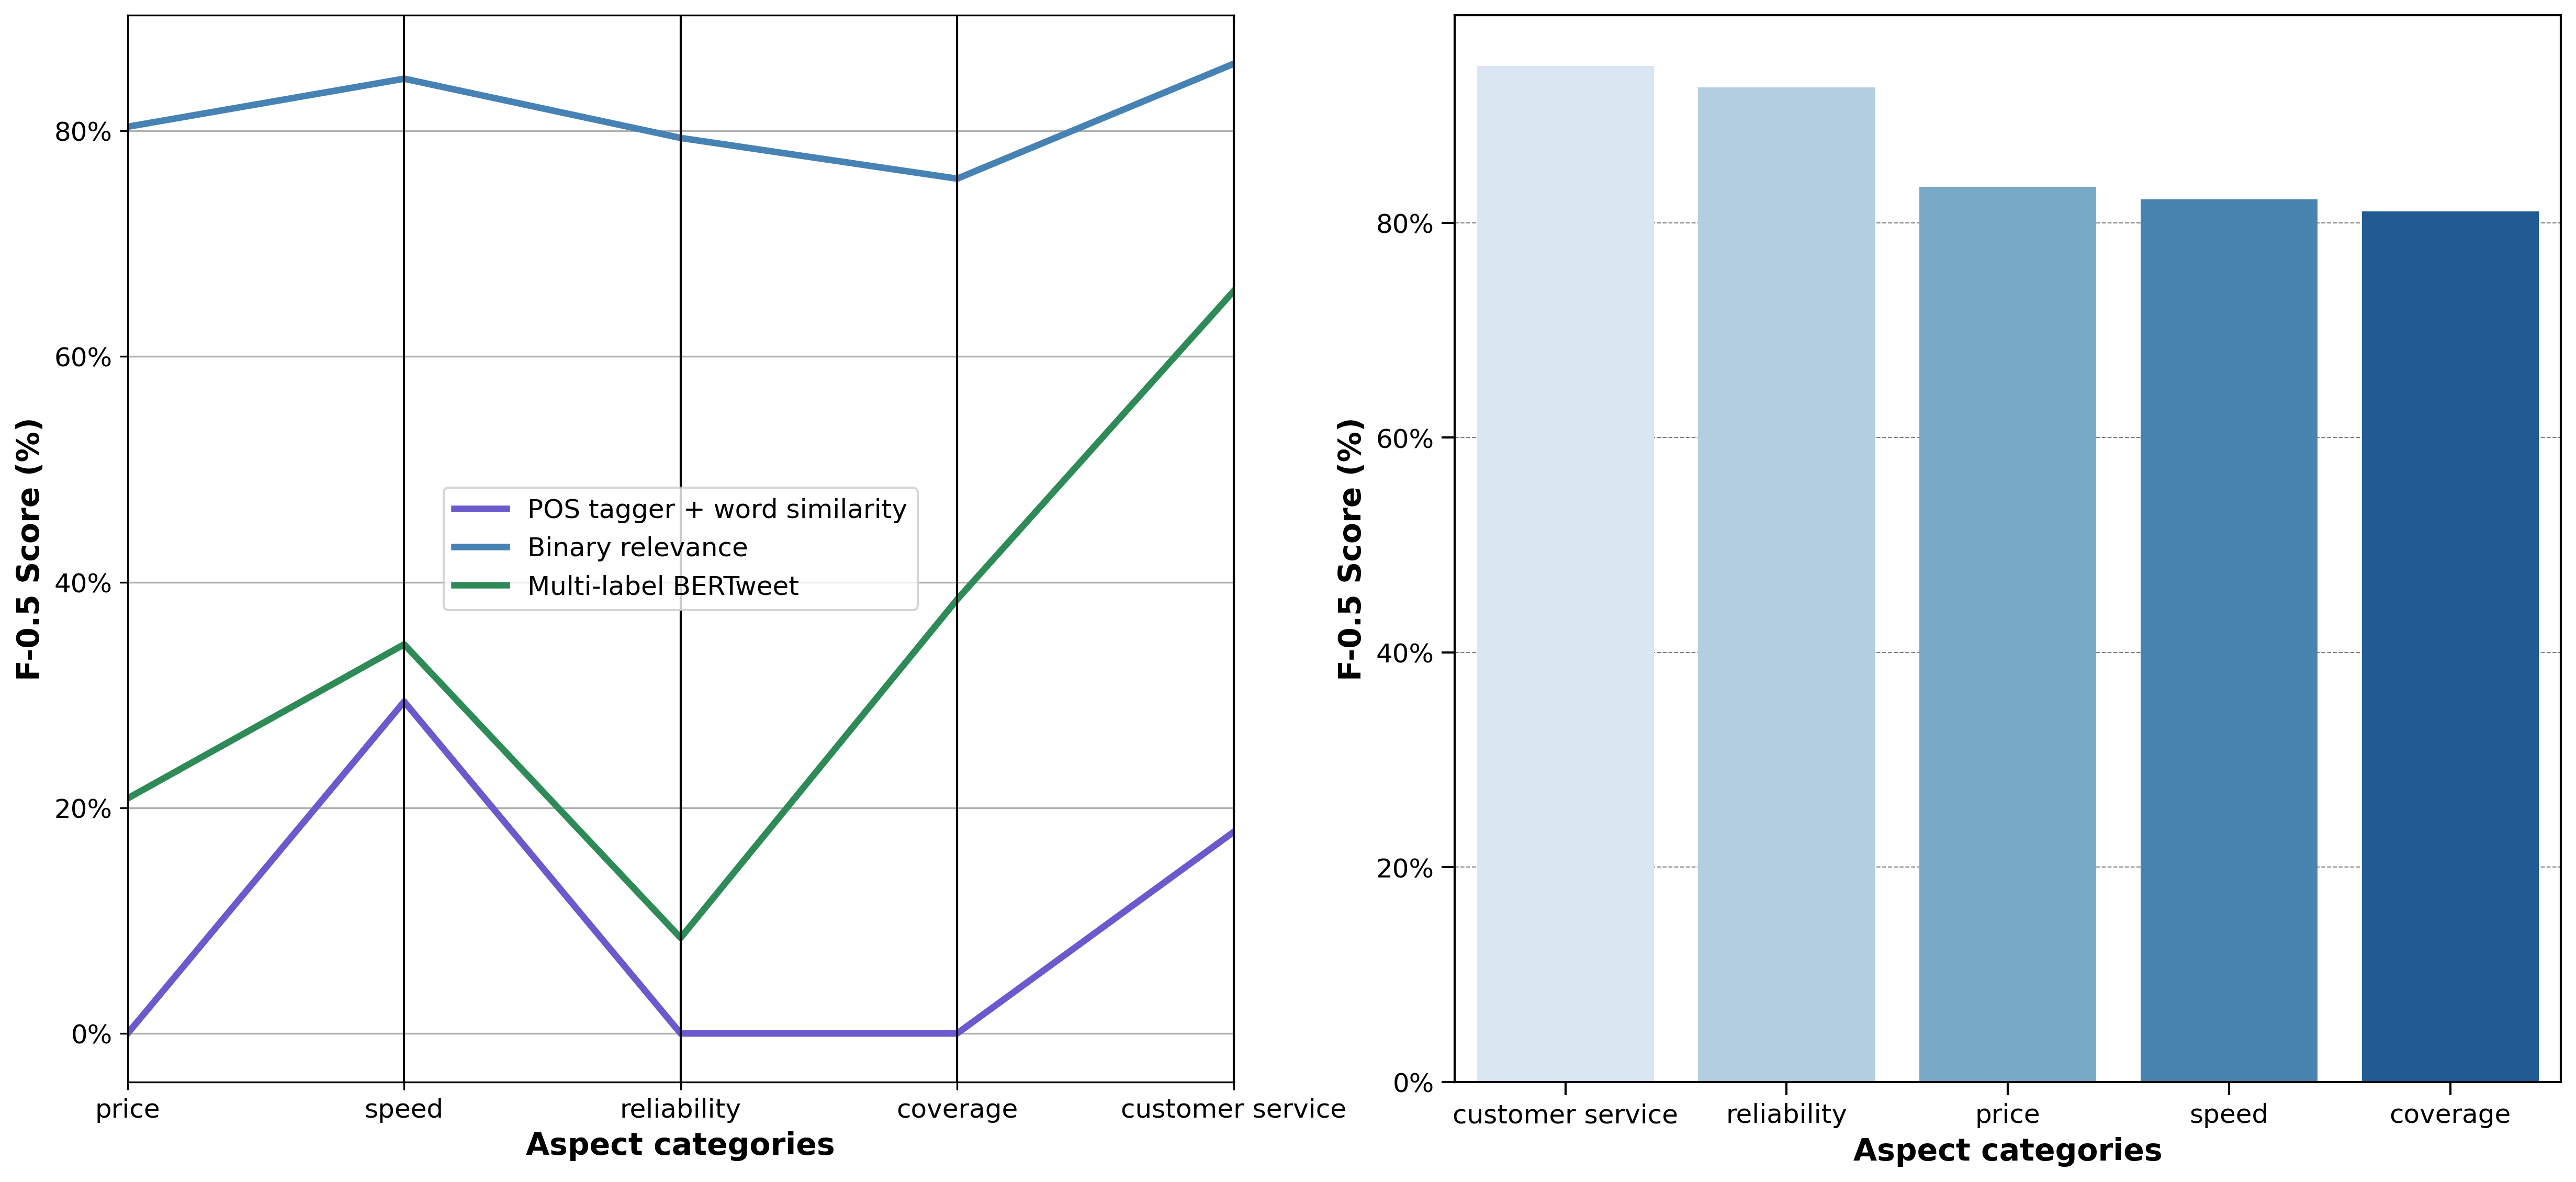

In [40]:
plt.figure(figsize=(20,9), dpi=300)

plt.subplot(1,2,1)
#Create plot
parallel_coordinates(joint_df,'model', linewidth=3, color=('slateblue','steelblue','seagreen'))
plt.ylabel('F-0.5 Score (%)',fontsize=14, fontweight= 'bold')
plt.xlabel('Aspect categories',fontsize=14, fontweight= 'bold')
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(loc='center', prop={'size': 12})
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 


with plt.style.context(['notebook','no-latex','grid']):
    plt.subplot(1,2,2)
    sns.barplot(data=pd.DataFrame(test_metrics_df.loc['F-0.5',:]).sort_values('F-0.5', ascending=False).T, 
                palette = "Blues")
    plt.ylabel('F-0.5 Score (%)',fontsize=14, fontweight= 'bold')
    plt.xlabel('Aspect categories',fontsize=14, fontweight= 'bold')
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.show()

## Plot sentiment prediction accuracy for the different aspects

### a. Aspect sentiment predictions for the validation set

In [16]:
val_accuracies = pd.DataFrame([md2_accuracies,md2_extraction_support]).T.rename(columns={0:'Accuracy',1:'Support'})
val_accuracies = val_accuracies.sort_values('Accuracy', ascending=False)
val_accuracies

,Accuracy,Support
reliability,1.000000,10.0
coverage,1.000000,5.0
customer service,0.909091,11.0
speed,0.636364,11.0
price,0.222222,9.0


### b. Compute aspect sentiment prediction for the test set

In [17]:
test_accuracies,test_micro_accuracy,test_macro_accuracy, test_extraction_support =aspect_sentiment_accuracy(binary_relevance_test_absa['Aspects'],
                                                                          binary_relevance_test_absa['Detected aspects'],
                                                                          binary_relevance_test_absa['Sentiment'],
                                                                          binary_relevance_test_absa['Predicted sentiment'])

print(f"Correct extractions:{test_extraction_support} \n Micro accuracy:{test_micro_accuracy:.3f}   Macro accuracy:{test_macro_accuracy:.3f}")

Correct extractions:{'price': 10, 'speed': 12, 'reliability': 10, 'coverage': 6, 'customer service': 7} 
 Micro accuracy:0.822   Macro accuracy:0.841


In [18]:
test_accuracies = pd.DataFrame([test_accuracies,test_extraction_support]).T.rename(columns={0:'Accuracy',1:'Support'})
test_accuracies = test_accuracies.sort_values('Accuracy', ascending=False)
test_accuracies

,Accuracy,Support
coverage,1.000000,6.0
reliability,0.900000,10.0
customer service,0.857143,7.0
speed,0.750000,12.0
price,0.700000,10.0


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


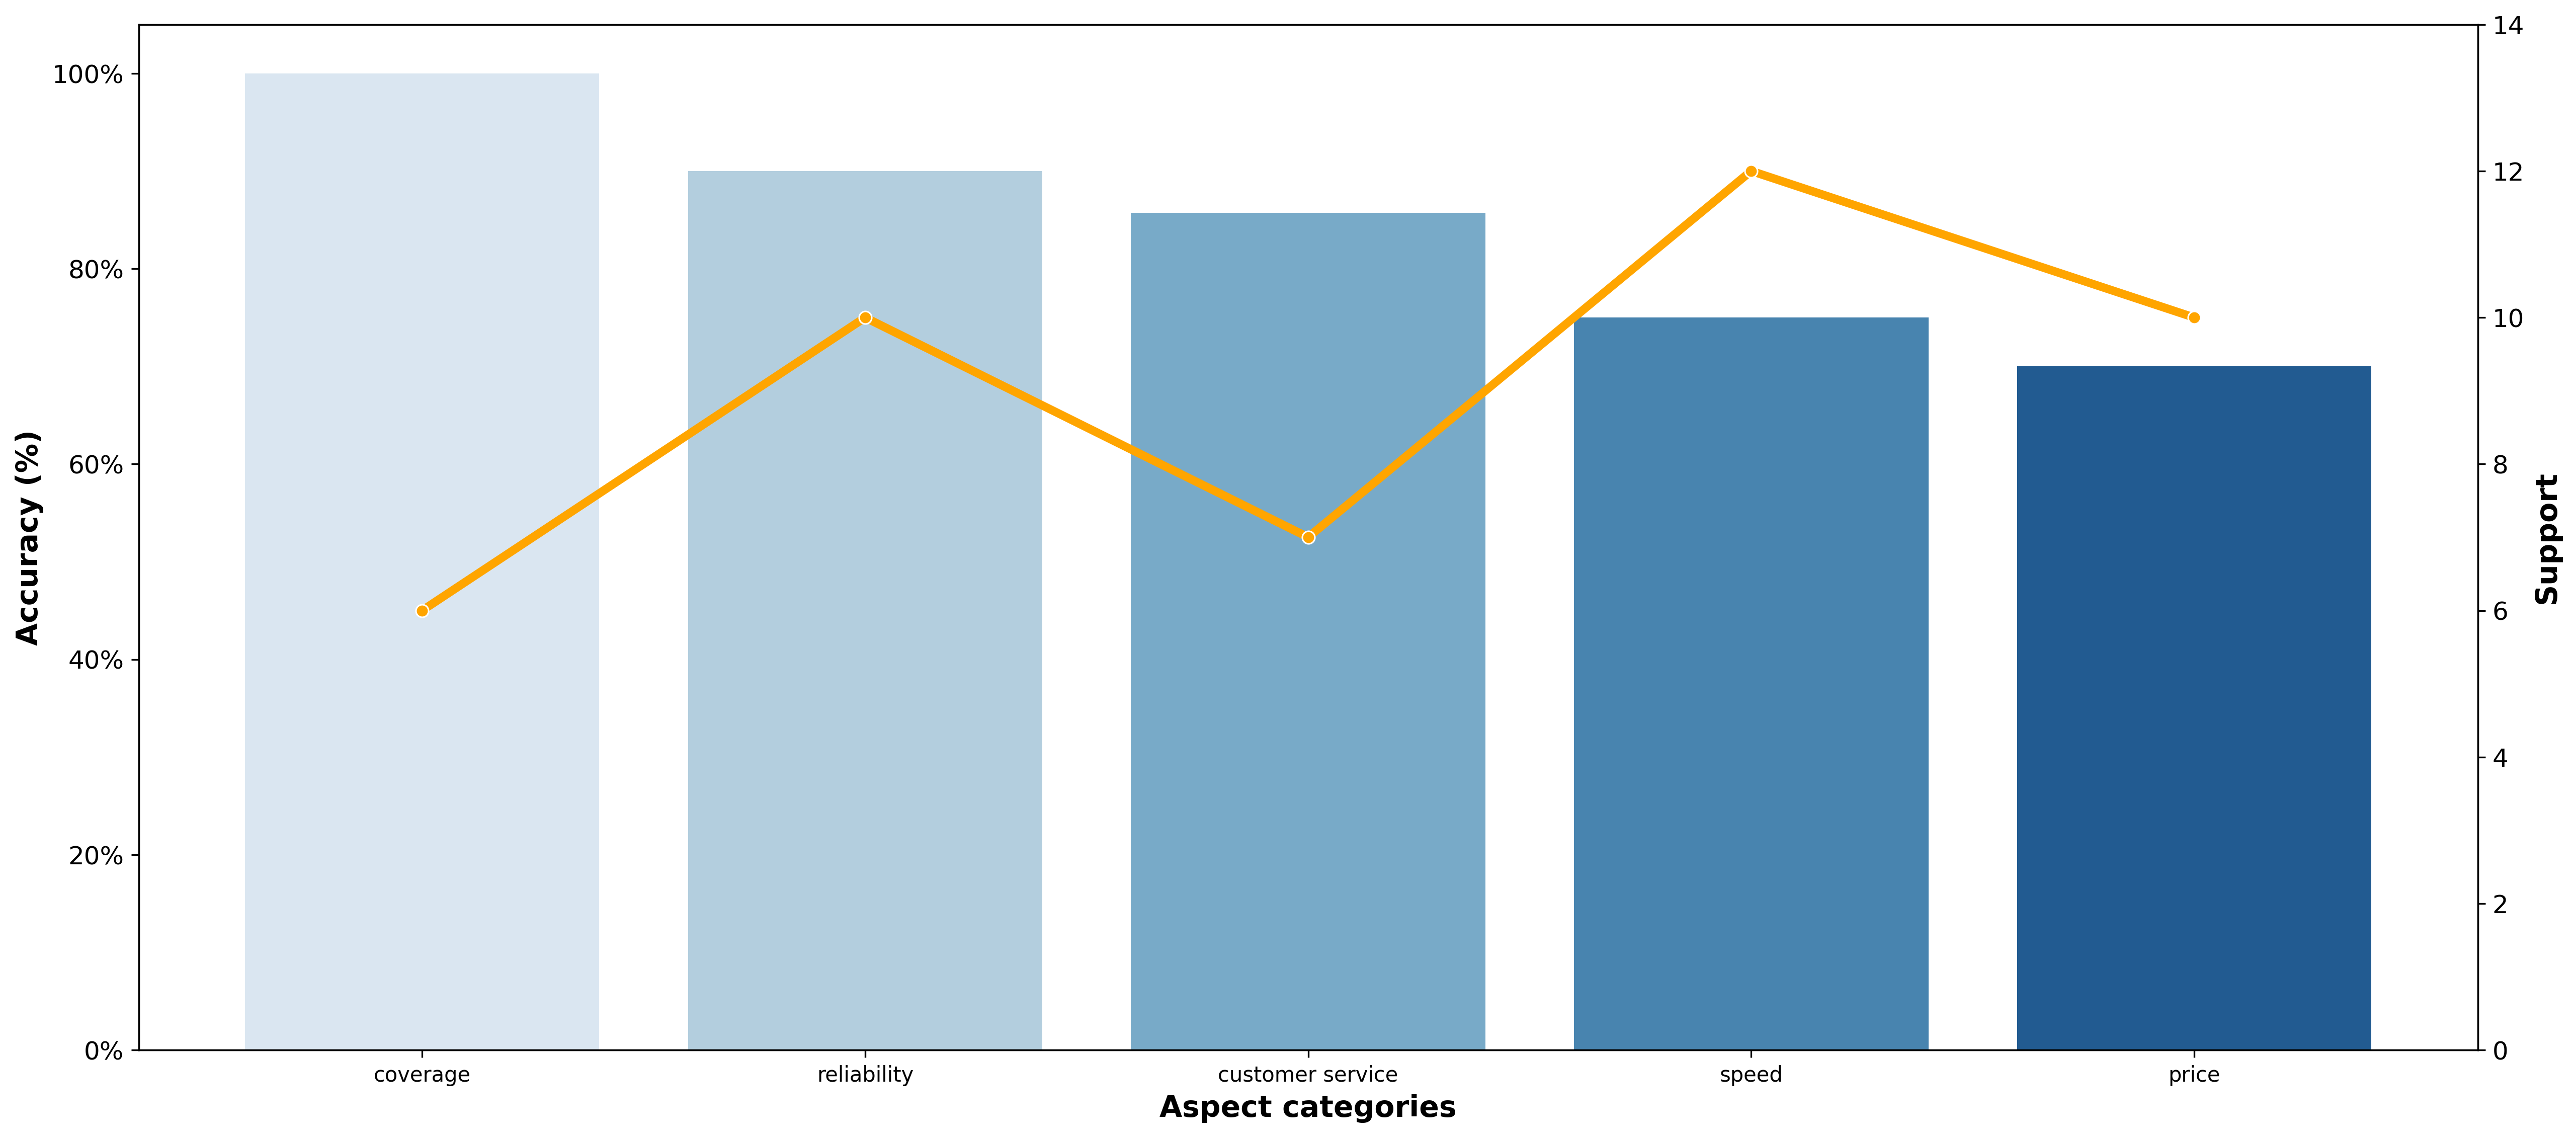

In [30]:
#with plt.style.context(['notebook','no-latex','grid']):
    
plt.figure(figsize=(20,9), dpi=300)

ax1 = sns.barplot(data=test_accuracies, x=test_accuracies.index, y= 'Accuracy', palette = "Blues", ci=None)
ax1.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax1.get_yticks()], fontsize = 12)
ax1.set_ylabel('Accuracy (%)',fontsize=14, fontweight= 'bold')
ax1.set_xlabel('Aspect categories',fontsize=14, fontweight= 'bold')

ax2 = plt.twinx(ax1)
sns.lineplot(data = test_accuracies, x=test_accuracies.index, y='Support',ax=ax2, color='orange',linewidth=4,marker="o")
ax2.set_ylabel('Support',fontsize=14, fontweight= 'bold')
ax2.set_ylim(0,14)

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in ax1.get_yticks()]) 

# ax.bar_label(ax.containers[0], 
#              labels = [int(x) for x in test_accuracies.Support], 
#              label_type='center', 
#              fontweight='semibold')

plt.show()

/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


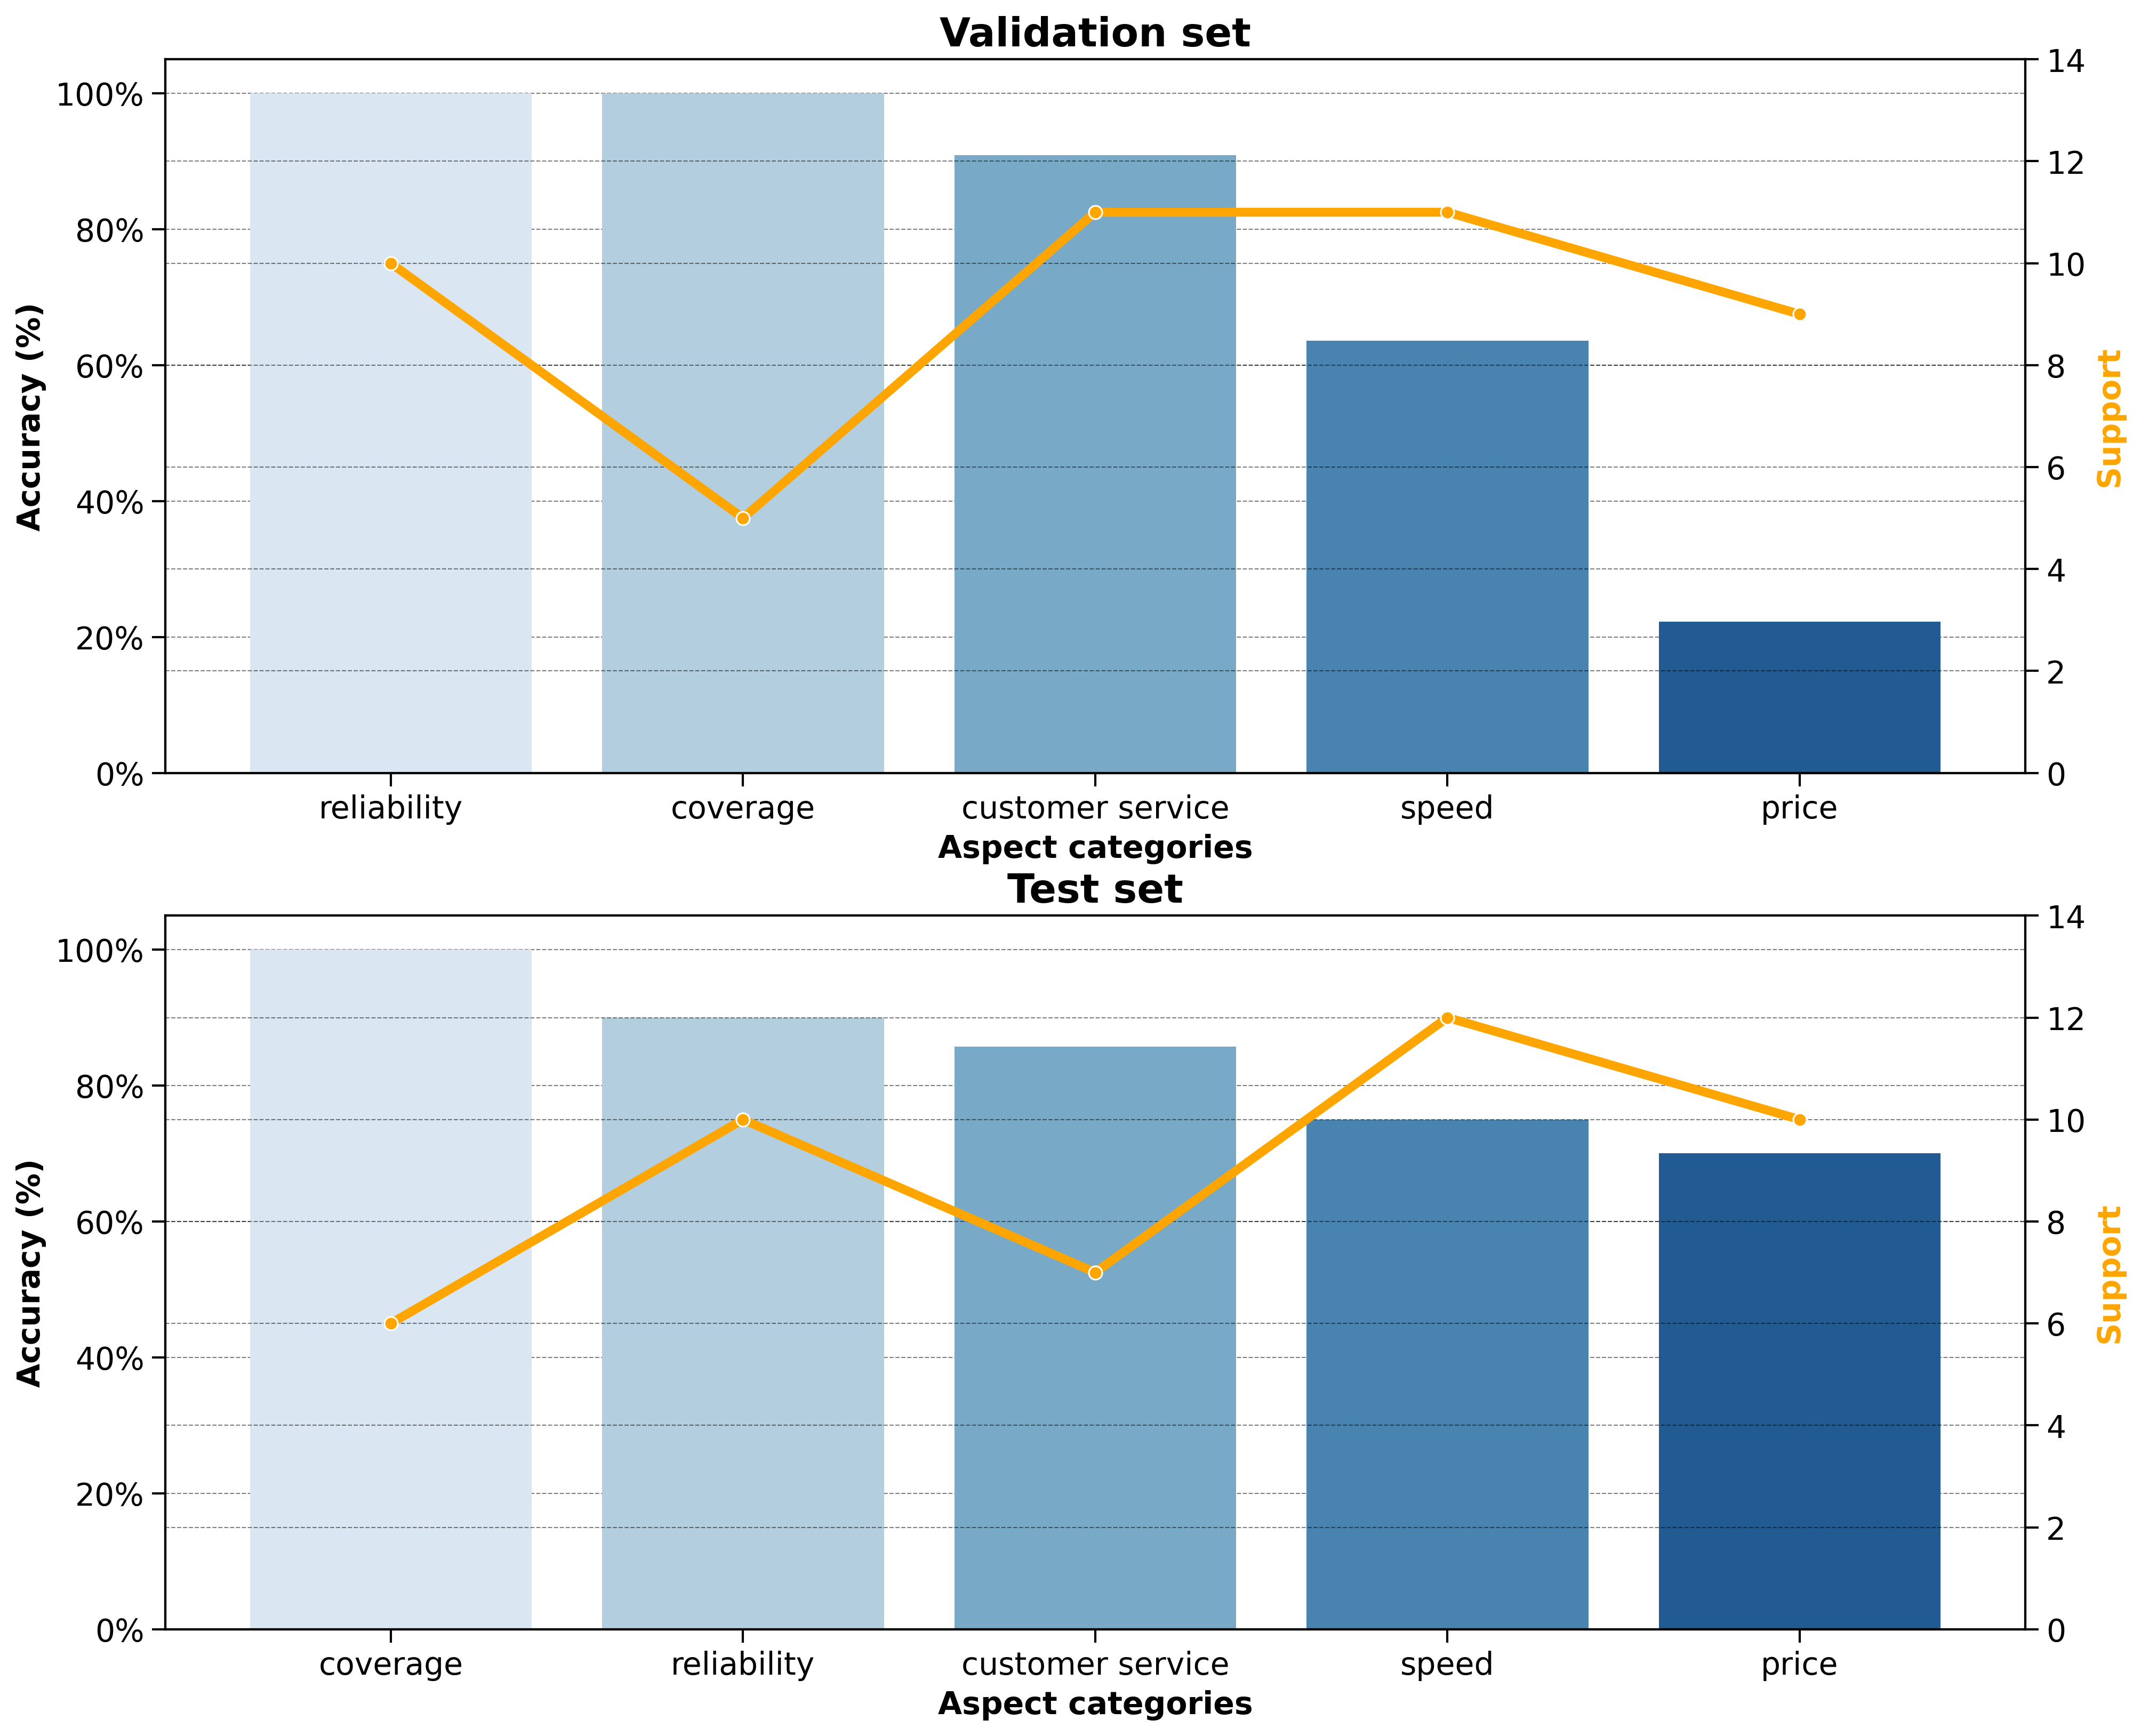

In [77]:
plt.figure(figsize=(15,13), dpi=300)
plt.tight_layout()

with plt.style.context(['notebook','no-latex','grid']):
    
    plt.subplot(2,1,1)
    ax1 = sns.barplot(data=val_accuracies, x=val_accuracies.index, y= 'Accuracy', palette = "Blues", ci=None)
    ax1.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax1.get_yticks()], fontsize = 14)
    ax1.set_ylabel('Accuracy (%)',fontsize=14, fontweight= 'bold')
    ax1.set_xlabel('Aspect categories',fontsize=14, fontweight= 'bold')
    ax1.set_xticklabels(ax1.get_xticks(), fontsize = 14)

    #Set subplot title
    ax1.axes.set_title('Validation set', fontdict={'fontsize': 18, 'fontweight': 'bold'})

    ax2 = plt.twinx(ax1)
    sns.lineplot(data = val_accuracies, x=val_accuracies.index, y='Support',ax=ax2, color='orange',linewidth=4,marker="o")
    ax2.set_ylim(0,14)
    ax2.set_ylabel('Support',fontsize=14, fontweight= 'bold',color='orange')
    ax2.set_yticklabels([int(x) for x in ax2.get_yticks()], fontsize = 14)


    plt.subplot(2,1,2)
    ax3 = sns.barplot(data=test_accuracies, x=test_accuracies.index, y= 'Accuracy', palette = "Blues", ci=None)
    ax3.set_yticklabels(['{:.0f}%'.format(x*100) for x in ax3.get_yticks()], fontsize = 14)
    ax3.set_ylabel('Accuracy (%)',fontsize=14, fontweight= 'bold')
    ax3.set_xlabel('Aspect categories',fontsize=14, fontweight= 'bold')
    ax3.set_xticklabels(ax3.get_xticks(), fontsize = 14)

    #Set subplot title
    ax3.axes.set_title('Test set', fontdict={'fontsize': 18, 'fontweight': 'bold'})

    ax4 = plt.twinx(ax3)
    sns.lineplot(data = test_accuracies, x=test_accuracies.index, y='Support',ax=ax4, color='orange',linewidth=4,marker="o")
    ax4.set_ylim(0,14)
    ax4.set_ylabel('Support',fontsize=14, fontweight= 'bold', color='orange')
    ax4.set_yticklabels([int(x) for x in ax4.get_yticks()], fontsize = 14)

    plt.show()


/Users/koredeakande/opt/anaconda3/envs/capstone/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


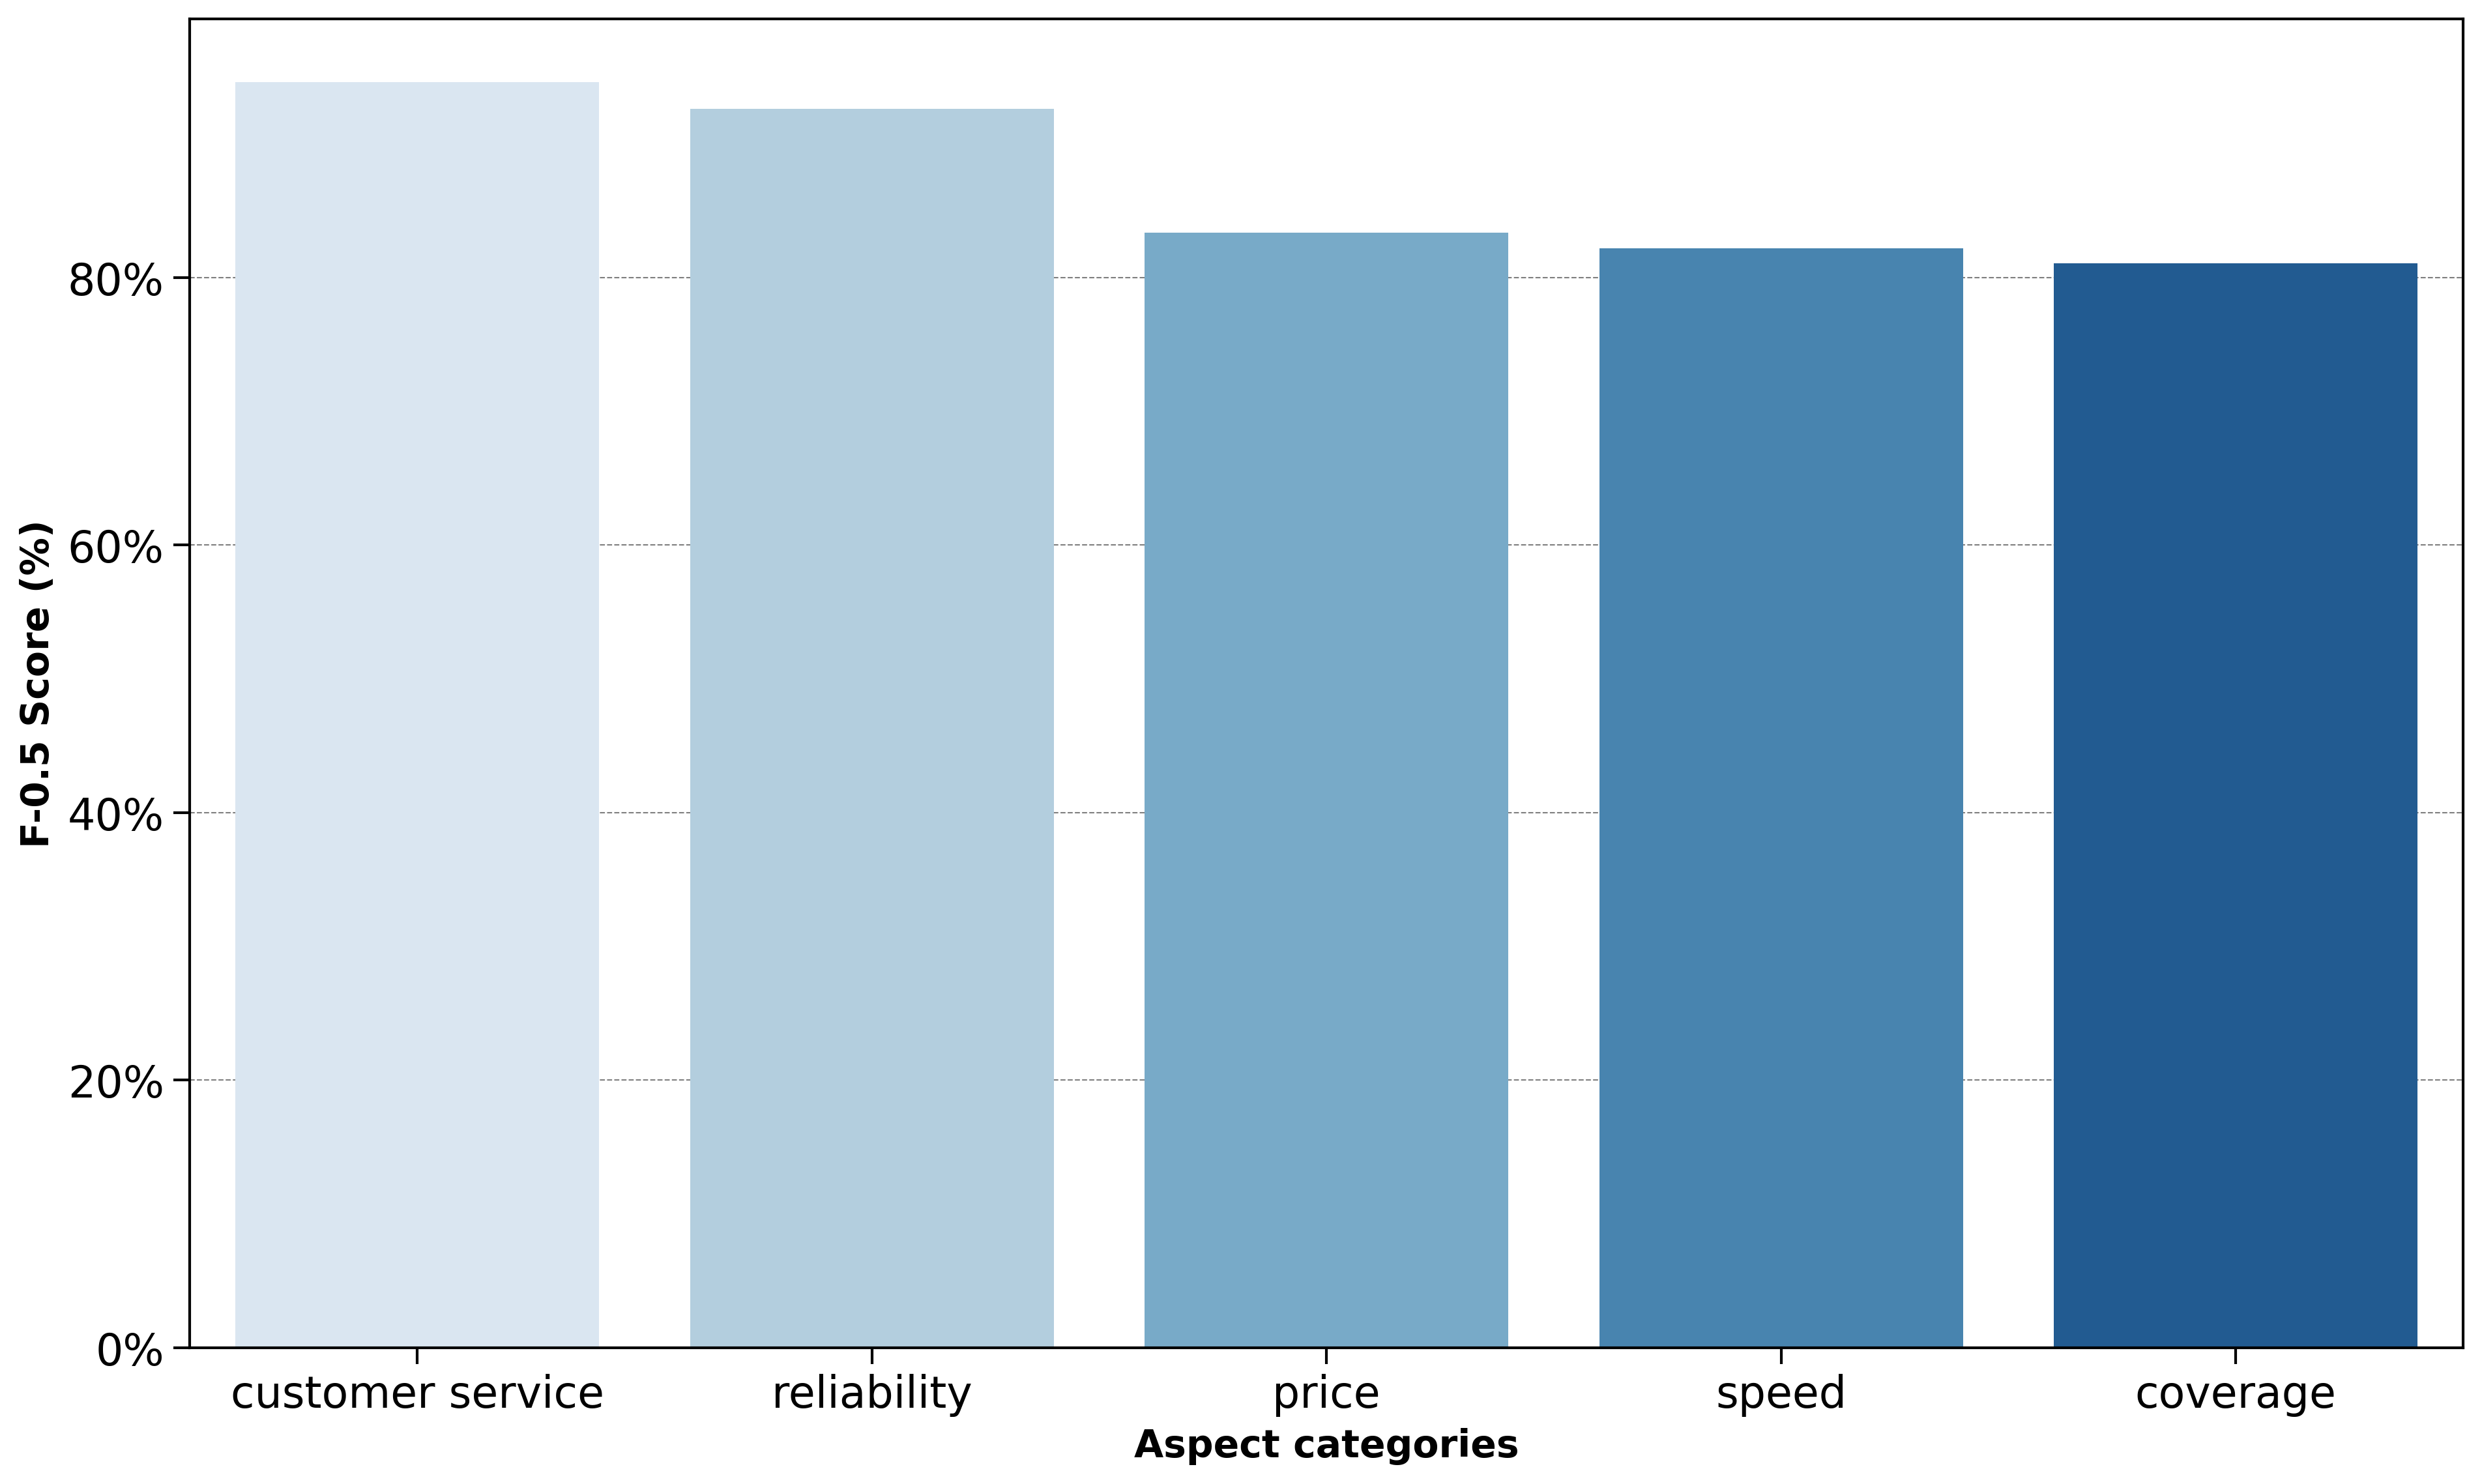

In [41]:
plt.figure(figsize=(15,9), dpi=300)
with plt.style.context(['notebook','no-latex','grid']):
    sns.barplot(data=pd.DataFrame(test_metrics_df.loc['F-0.5',:]).sort_values('F-0.5', ascending=False).T, 
                palette = "Blues")
    plt.ylabel('F-0.5 Score (%)',fontsize=14, fontweight= 'bold')
    plt.xlabel('Aspect categories',fontsize=14, fontweight= 'bold')
    plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
    plt.show()